# Deep learning for timeseries

## Timeseries Forecasting Appliation

The most common timeseries-related task is forecasting: predicting what will happen next in a series:

* Forecast ***electricity consumption*** a few hours in advance so you can anticipate demand
* Forecast ***revenue*** a few months in advance so you can plan your budget
* Forecast the ***weather*** a few days in advance so you can plan your schedule

## A temperature-forecasting example

Code examples will target a single problem:

* Predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the recent past by a set of sensors on the roof of a building.

Work with a weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany.1 In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years

In [ ]:
# download the data
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-01-10 10:37:55--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.220.24, 54.231.225.216, 52.217.73.30, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.220.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.7MB/s    in 0.9s    

2024-01-10 10:37:56 (13.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [ ]:
import pandas as pd
import os

In [ ]:
fname = os.path.join("jena_climate_2009_2016.csv")

data = pd.read_csv(fname)
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
with open(fname) as f:
    data = f.read()

lines = data.split("\n")
# print(lines[0])
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(f"Output of {len(lines)} lines of data")

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Output of 420451 lines of data


**Parsing the data**

Convert all 420,451 lines of data into NumPy arrays:
* One array for the temperature (in degrees Celsius),
* And another one for the rest of the data—the features we will use to predict future temperatures.

Note that we discard the “Date Time” column

In [ ]:
import numpy as np
# initialize an array with zeros and then populate it with actual data
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    # store column 1 in the “temperature” array
    temperature[i] = values[1]
    # store all columns (including the temperature) in the “raw_data” array
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

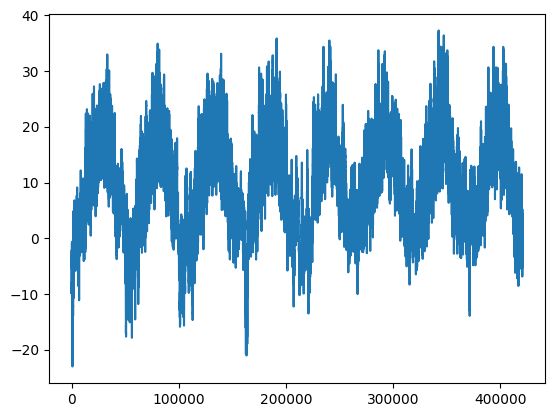

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

Plot the first *10 days* of temperature data while data is recorded every *10 minutes*, for *24 hours* per day.

24x(10x6)x10 = 1440

Text(0.5, 1.0, 'Temperature over the first 10 days of the dataset (ºC)')

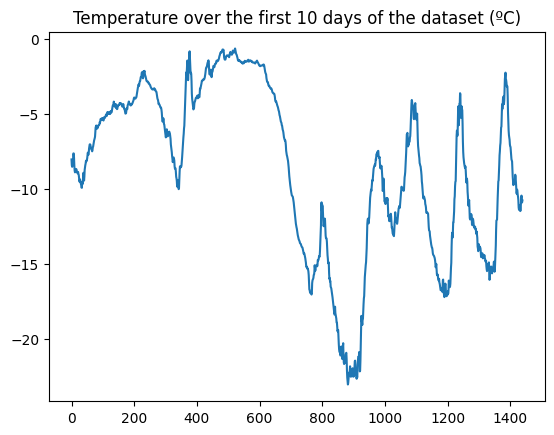

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.title("Temperature over the first 10 days of the dataset (ºC)")

**Computing the number of samples we'll use for each data split**

Use 50% of the data for training, the following 25% for validation, and the last 25% for testing

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

Preprocess the data to a format a neural network can ingest.  

* Since each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per mole, is around 3), we’ll normalize each timeseries independently so that they all take small values on a similar scale.

* Use the first 210,225 timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data

**Normalizing the data**

In [ ]:
raw_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

In [ ]:
raw_data[:num_train_samples]

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.8728e+02,  7.5600e+00,  2.8175e+02, ...,  4.7500e+00,
         6.6500e+00,  1.9860e+02],
       [ 9.8736e+02,  7.4800e+00,  2.8166e+02, ...,  4.4600e+00,
         6.0100e+00,  1.8650e+02],
       [ 9.8733e+02,  7.3000e+00,  2.8148e+02, ...,  4.0000e+00,
         6.0500e+00,  1.7810e+02]])

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**Understanding timeseries_dataset_from_array()**

For example, if you use data = [0 1 2 3 4 5 6]

and sequence_length=3,

then timeseries_dataset_from_array() will generate the following samples: [0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6].

In [ ]:
import numpy as np
from tensorflow import keras
# Generate an array of sorted integers from 0 to 9
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    # The sequences we generate will be sampled from int_sequence
    data=int_sequence[:-3],
    # The target for the sequence that starts at data[N] will be data[N + 3].
    targets=int_sequence[3:],
    # The sequences will be 3 steps long.
    sequence_length=3,
    # The sequences will be batched in batches of size 2
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

Use timeseries_dataset_from_array() to instantiate three datasets: one for training, one for validation, and one for testing.

We’ll use the following parameter values:
* sampling_rate = 6—Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
* sequence_length = 120—Observations will go back 5 days (120 hours).
* delay = sampling_rate * (sequence_length + 24 - 1)—The target for a sequence will be the temperature 24 hours after the end of the sequence.

When making the training dataset, we’ll pass start_index = 0 and end_index = num_train_samples to only use the first 50% of the data.

For the validation dataset, we’ll pass start_index = num_train_samples and end_index = num_train_samples + num_val_samples to use the next 25% of the data.

Finally, for the test dataset, we’ll pass start_index = num_train_samples + num_val_samples to use the remaining samples

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

Before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits

The code below shows a fully connected model that starts by:
* Flattening the data and then runs it through two Dense layers. Note the lack of an activation function on the last Dense layer, which is typical for a regression problem.
* Using mean squared error (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth around zero, which is a useful property for gradient descent.
* Monitor MAE by adding it as a metric in compile().

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    # save the best performaing model
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# reload the best model and evaluate it on the test data
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 52s 62ms/step - loss: 12.6845 - mae: 2.7573 - val_loss: 15.4916 - val_mae: 3.1506
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 9.0995 - mae: 2.3728 - val_loss: 11.3628 - val_mae: 2.6811
Epoch 3/10
819/819 [==============================] - 43s 53ms/step - loss: 8.2559 - mae: 2.2631 - val_loss: 10.8769 - val_mae: 2.6096
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 7.7874 - mae: 2.2004 - val_loss: 13.1103 - val_mae: 2.8682
Epoch 5/10
819/819 [==============================] - 50s 61ms/step - loss: 7.4769 - mae: 2.1567 - val_loss: 10.4357 - val_mae: 2.5489
Epoch 6/10
819/819 [==============================] - 51s 62ms/step - loss: 7.2407 - mae: 2.1244 - val_loss: 11.6688 - val_mae: 2.7014
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 7.0785 - mae: 2.1016 - val_loss: 13.0550 - val_mae: 2.8710
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

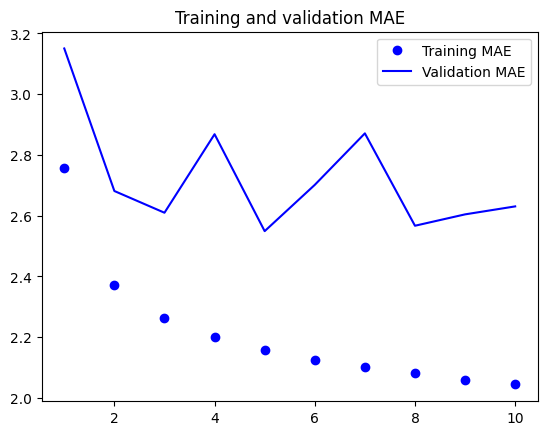

In [ ]:
# display the loss curves for validation and training
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform.

### Let's try a 1D convolutional model

Conv1D is used for processing one-dimensional sequential data, such as text or time series

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 79s 95ms/step - loss: 21.8450 - mae: 3.6569 - val_loss: 18.6099 - val_mae: 3.4435
Epoch 2/10
819/819 [==============================] - 89s 108ms/step - loss: 15.3590 - mae: 3.1145 - val_loss: 16.2811 - val_mae: 3.1828
Epoch 3/10
819/819 [==============================] - 80s 97ms/step - loss: 14.0942 - mae: 2.9778 - val_loss: 13.2547 - val_mae: 2.8810
Epoch 4/10
819/819 [==============================] - 77s 94ms/step - loss: 13.3387 - mae: 2.8910 - val_loss: 13.5262 - val_mae: 2.9156
Epoch 5/10
819/819 [==============================] - 82s 100ms/step - loss: 12.7532 - mae: 2.8271 - val_loss: 13.6841 - val_mae: 2.9320
Epoch 6/10
819/819 [==============================] - 84s 103ms/step - loss: 12.3449 - mae: 2.7797 - val_loss: 16.1678 - val_mae: 3.1846
Epoch 7/10
819/819 [==============================] - 78s 95ms/step - loss: 11.9966 - mae: 2.7383 - val_loss: 15.0611 - val_mae: 3.0677
Epoch 8/10
819/819 [=========================

**Plotting results**

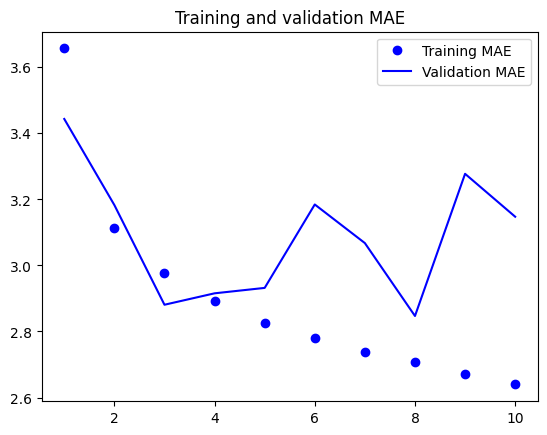

In [ ]:
# Training and validation MAE on the Jena temperatureforecasting task with a 1D convnet
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### A first recurrent baseline

**A simple LSTM-based model**

Try LSTM for a better result

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 102s 122ms/step - loss: 40.5528 - mae: 4.6212 - val_loss: 12.1611 - val_mae: 2.6632
Epoch 2/10
819/819 [==============================] - 100s 122ms/step - loss: 10.6600 - mae: 2.5408 - val_loss: 9.6334 - val_mae: 2.4100
Epoch 3/10
819/819 [==============================] - 101s 123ms/step - loss: 9.6788 - mae: 2.4268 - val_loss: 9.5367 - val_mae: 2.3962
Epoch 4/10
819/819 [==============================] - 117s 143ms/step - loss: 9.1863 - mae: 2.3662 - val_loss: 9.8854 - val_mae: 2.4490
Epoch 5/10
819/819 [==============================] - 117s 142ms/step - loss: 8.8003 - mae: 2.3136 - val_loss: 9.8940 - val_mae: 2.4547
Epoch 6/10
819/819 [==============================] - 99s 120ms/step - loss: 8.5085 - mae: 2.2737 - val_loss: 10.1035 - val_mae: 2.4728
Epoch 7/10
819/819 [==============================] - 102s 124ms/step - loss: 8.2424 - mae: 2.2349 - val_loss: 10.1439 - val_mae: 2.4684
Epoch 8/10
819/819 [========================

**Plotting result**

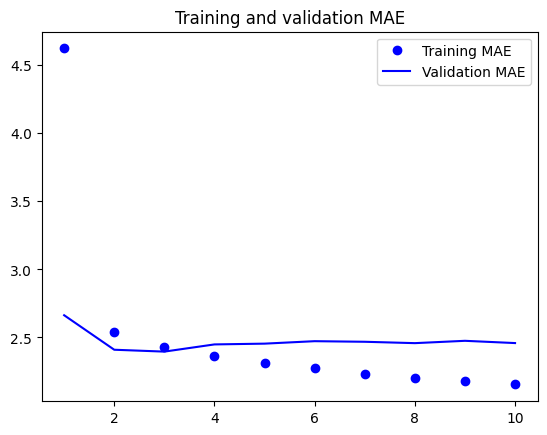

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [ ]:
# More-detailed pseudocode for the RNN
# state_t = 0
# for input_t in input_sequence:
# output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
# state_t = output_t

In [ ]:
import numpy as np

# number of timesteps in the input sequence
timesteps = 100
# dimensionality of the input and output feature space
input_features = 32
output_features = 64

# input data: random noise for the sake of the example
inputs = np.random.random((timesteps, input_features))
# initial state: an all-zero vector (stores information about the previous inputs processed by the network)
state_t = np.zeros((output_features,))
# create random weight matrices
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
# input_t is a vecor of shape (input_features,)
for input_t in inputs:
    # combines the input with the current state (the previous output) to obtain the current output
    # use tanh() to add non-linearity (could use any other activation function)
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    # stores this output in alist
    successive_outputs.append(output_t)
    # updates the state of the network for the next timestep
    state_t = output_t
# the final output is a rank-2 tensor of shape (timesteps, output_feature)
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
num_features = 14
# set the timesteps entry to None
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns only its last output step**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
# return_sequences=False is the default
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
print(outputs.shape)

(None, 16)


## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 215s 259ms/step - loss: 26.9172 - mae: 3.8275 - val_loss: 9.6219 - val_mae: 2.4180
Epoch 2/50
819/819 [==============================] - 211s 258ms/step - loss: 14.8008 - mae: 2.9895 - val_loss: 9.3478 - val_mae: 2.3748
Epoch 3/50
819/819 [==============================] - 211s 258ms/step - loss: 14.0247 - mae: 2.9055 - val_loss: 9.3165 - val_mae: 2.3619
Epoch 4/50
819/819 [==============================] - 212s 259ms/step - loss: 13.4439 - mae: 2.8391 - val_loss: 9.5133 - val_mae: 2.3768
Epoch 5/50
819/819 [==============================] - 211s 257ms/step - loss: 12.8950 - mae: 2.7837 - val_loss: 9.3442 - val_mae: 2.3621
Epoch 6/50
819/819 [==============================] - 198s 242ms/step - loss: 12.4728 - mae: 2.7356 - val_loss: 9.4333 - val_mae: 2.3739
Epoch 7/50
819/819 [==============================] - 198s 241ms/step - loss: 12.2109 - mae: 2.7048 - val_loss: 9.7936 - val_mae: 2.4142
Epoch 8/50
819/819 [=====================

In [ ]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 33s 81ms/step - loss: 11.7097 - mae: 2.6875
Test MAE: 2.69


In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

**Plotting results**

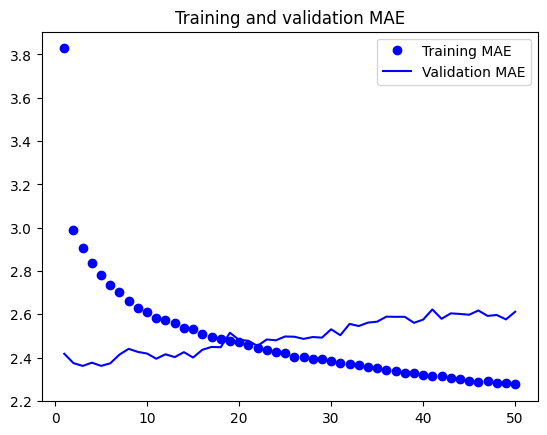

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 340s 408ms/step - loss: 25.8181 - mae: 3.7433 - val_loss: 9.7596 - val_mae: 2.4203
Epoch 2/50
819/819 [==============================] - 335s 409ms/step - loss: 14.0962 - mae: 2.9105 - val_loss: 9.2046 - val_mae: 2.3579
Epoch 3/50
819/819 [==============================] - 332s 405ms/step - loss: 13.3592 - mae: 2.8338 - val_loss: 9.9544 - val_mae: 2.4577
Epoch 4/50
819/819 [==============================] - 332s 406ms/step - loss: 12.7402 - mae: 2.7656 - val_loss: 9.3709 - val_mae: 2.3785
Epoch 5/50
819/819 [==============================] - 336s 410ms/step - loss: 12.2290 - mae: 2.7130 - val_loss: 8.9820 - val_mae: 2.3268
Epoch 6/50
819/819 [==============================] - 339s 414ms/step - loss: 11.7841 - mae: 2.6649 - val_loss: 8.9807 - val_mae: 2.3359
Epoch 7/50
819/819 [==============================] - 333s 406ms/step - loss: 11.4023 - mae: 2.6253 - val_loss: 9.4235 - val_mae: 2.3808
Epoch 8/50
819/819 [=====================

**Plotting results**

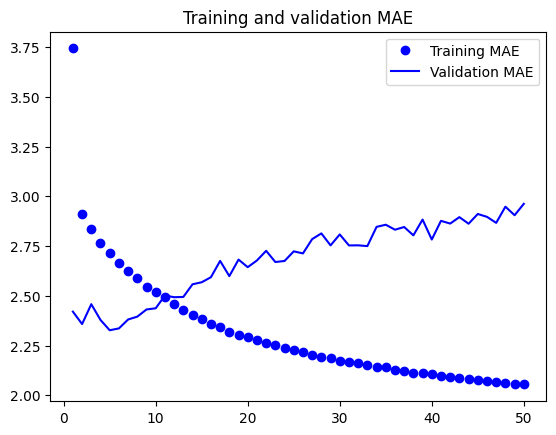

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**


RNNs are notably order-dependent:
* they process the timesteps of their input sequences in order,
* and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence.
* This is precisely the reason they perform well on problems where order is meaningful, such as the temperature forecasting problem.

A bidirectional RNN exploits the order sensitivity of RNNs:
* it uses two regular RNNs, such as the GRU and LSTM layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merges their representations.
* By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 161s 191ms/step - loss: 28.9374 - mae: 3.8435 - val_loss: 10.5075 - val_mae: 2.5228
Epoch 2/10
819/819 [==============================] - 145s 177ms/step - loss: 9.4464 - mae: 2.3975 - val_loss: 9.8875 - val_mae: 2.4316
Epoch 3/10
819/819 [==============================] - 142s 173ms/step - loss: 8.6195 - mae: 2.2916 - val_loss: 9.6216 - val_mae: 2.4038
Epoch 4/10
819/819 [==============================] - 154s 188ms/step - loss: 8.0944 - mae: 2.2230 - val_loss: 10.1962 - val_mae: 2.4675
Epoch 5/10
819/819 [==============================] - 154s 188ms/step - loss: 7.6819 - mae: 2.1739 - val_loss: 10.8714 - val_mae: 2.5458
Epoch 6/10
819/819 [==============================] - 149s 182ms/step - loss: 7.3067 - mae: 2.1210 - val_loss: 10.8726 - val_mae: 2.5643
Epoch 7/10
819/819 [==============================] - 153s 186ms/step - loss: 7.0254 - mae: 2.0785 - val_loss: 10.8107 - val_mae: 2.5479
Epoch 8/10
819/819 [======================

In [ ]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 32s 78ms/step - loss: 11.7097 - mae: 2.6875
Test MAE: 2.69


**Plotting results**

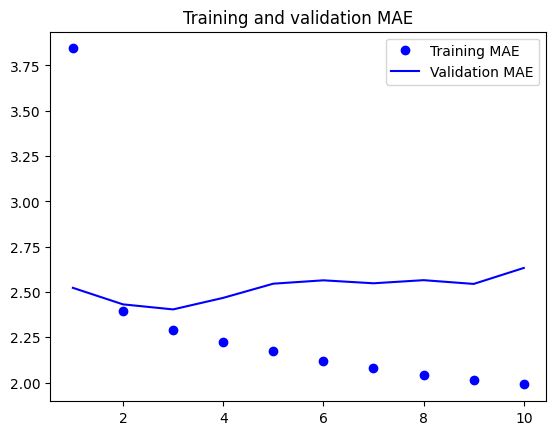

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()